In [468]:
import pickle
import pandas as pd
import numpy as np
import os
import FinanceDataReader as fdr
import torch
import torchvision
from pykrx import stock
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime, timedelta

In [469]:
class Net(torch.nn.Module): # Network 구조 - RNN 통과 이후에 linear layer들을 적당히 통과시켜서 구현함
    def __init__(self, input_dim, hidden_dim, output_dim, layers_rnn, layers_fc):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers_rnn, batch_first=True)
        fclist = []
        for i in range(layers_fc - 1): # layers_fc should be over 1
            fclist.append(torch.nn.Linear(hidden_dim, hidden_dim, bias=True))
            fclist.append(torch.nn.ReLU())
        
        self.fc_seq = torch.nn.Sequential(*fclist)
        self.fc_last = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc_seq(x)
        x = self.fc_last(x)
        x = x[:, [-1], :].view(-1, output_seq_length)
        return x

In [470]:
class newNet(torch.nn.Module): # 새 network FC - RNN - FC
    def __init__(self, input_dim, hidden_dim, output_dim, layers_rnn, layers_fc):
        super(newNet, self).__init__()
        fcinlist = []
        fcinlist.append(torch.nn.Linear(input_dim, hidden_dim, bias=True))
        for i in range(layers_fc - 1): # layers_fc should be over 1
            fcinlist.append(torch.nn.Linear(hidden_dim, hidden_dim, bias=True))
            fcinlist.append(torch.nn.ReLU())
        self.fc_in = torch.nn.Sequential(*fcinlist)
        self.rnn = torch.nn.LSTM(hidden_dim, hidden_dim, num_layers=layers_rnn, batch_first=True)
        fclist = []
        for i in range(layers_fc - 1): # layers_fc should be over 1
            fclist.append(torch.nn.Linear(hidden_dim, hidden_dim, bias=True))
            fclist.append(torch.nn.ReLU())
        
        self.fc_seq = torch.nn.Sequential(*fclist)
        self.fc_last = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x = self.fc_in(x)
        x, _status = self.rnn(x)
        x = self.fc_seq(x)
        x = self.fc_last(x)
        x = x[:, [-1], :].view(-1, output_seq_length)
        return x

In [471]:
seq_length = 50 # 이전 3일의 데이터를 가지고 예측함
stock_num = 368 # 10종목의 주식을 가지고 학습, 예측함
train_portion = 0.8 # 80%의 데이터로 학습, 20%의 데이터로 테스트
learning_rate = 1e-4 # 학습률(아마 이미 적당한 값인 것 같음)
output_seq_length = 5 # 이후 5일의 데이터를 예측
test_len = 1 # 테스트 데이터의 길이를 150으로 고정

start_year = '2019'
end_year = '2022'

start_date = start_year + '0101'
end_date = end_year + '0527'  # 2020 01월 01일 ~ 2022년 5월 1일 데이터 load
start_date_y = start_year + '-01-01'
end_date_y = end_year + '-05-27'

In [472]:
with open('stock_dic_all.txt', 'rb') as file1:
    stock_dic = pickle.load(file1)

In [473]:
torch.manual_seed(0) # 랜덤 시드 처리
device = 'cuda' if torch.cuda.is_available() else 'cpu' # GPU를 활용 가능하면 GPU로 학습함
print("Using", device)

net = newNet(41, 32, output_seq_length, 1, 10).to(device)

criterion = torch.nn.MSELoss() # 단순한 MeanSquareLoss를 Loss롤 잡아 Loss를 최소화시키는 방향으로 학습하기로 함
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate) # Adam optimizer 사용, 학습률 설정

name = "181489_1304347826_all_32_1_20_10stocks_seq30_2019_EPOCH450.tar"

net.load_state_dict(
    torch.load("./new_models/" + name)['model']
)

optimizer.load_state_dict(
    torch.load("./new_models/" + name)['optimizer']
)

Using cuda


<All keys matched successfully>

In [474]:
def build_dataset(time_series, seq_length, output_seq_length): # time series로 input을 받고, seq_length만큼 잘라서 입력 데이터 구성,
                                                               # output_seq_length만큼 잘라서 출력 데이터 구성
    dataX = []
    dataY = []
    for i in range(0, 1 + len(time_series) - seq_length - output_seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length:i + seq_length + output_seq_length, [0]]
        dataX.append(_x)
        dataY.append(_y)
    
    return np.array(dataX), np.array(dataY)

In [475]:
def minmax_scaler(data): # 데이터의 값들을 0~1 사이의 값으로 조정함 -> Normalization을 거치면 학습이 훨씬 잘 되는 것은 이미 확인하였음
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [476]:
def data_load(stock_dict): # stock_dict로 pandas dataframe 형식의 데이터를 받아
                           # train, test data를 만들어 냄, 이 때 train, test는 0~1사이의 값으로 scale된 것임
                           # train_non_scaled가 scale 되지 않은 데이터 -> 이 데이터는 테스트시에만 사용
    stock_names = []
    trainX = []
    testX = []
    trainY = []
    testY = []
    testX_non_scaled = []
    testY_non_scaled = []
    for stock_name in stock_dict:
        stock_names.append(stock_name)
        input_data = stock_dict[stock_name]['df']
        output_data = stock_dict[stock_name]['target_list']
        input_data = input_data.values[:, 1:].astype(np.float64)
        
        #train_size = int(len(input_data) * train_portion)
        train_tmp = input_data[0:len(input_data) - output_seq_length]
        test_tmp = input_data[len(input_data) - seq_length - output_seq_length - test_len + 1:]

        testX_non_scaled_tmp, testY_non_scaled_tmp = build_dataset(test_tmp, seq_length, output_seq_length)

        train_tmp = minmax_scaler(train_tmp)
        test_tmp = minmax_scaler(test_tmp)

        trainX_tmp, trainY_tmp = build_dataset(train_tmp, seq_length, output_seq_length)
        testX_tmp, testY_tmp = build_dataset(test_tmp, seq_length, output_seq_length)
        
        trainX_tmp = torch.FloatTensor(trainX_tmp).to(device)
        testX_tmp = torch.FloatTensor(testX_tmp).to(device)
        testX_non_scaled_tmp = torch.FloatTensor(testX_non_scaled_tmp).to(device)
        trainY_tmp = torch.FloatTensor(trainY_tmp).to(device)
        testY_tmp = torch.FloatTensor(testY_tmp).to(device)
        testY_non_scaled_tmp = torch.FloatTensor(testY_non_scaled_tmp).to(device)

        trainX.append(trainX_tmp)
        trainY.append(trainY_tmp.view(-1, output_seq_length))
        testX.append(testX_tmp)
        testY.append(testY_tmp.view(-1, output_seq_length))
        testX_non_scaled.append(testX_non_scaled_tmp)
        testY_non_scaled.append(testY_non_scaled_tmp.view(-1, output_seq_length))
    return trainX, trainY, testX, testY, testX_non_scaled, testY_non_scaled, stock_names

In [477]:
# NaN 값이 loss 계산을 Nan으로 만들어버리기에 0으로 채움(추후에 이 값은 바꿀 가능성 높음 -> 가까운 값을 사용하는 것으로 변경(minmax scaler의 효율))
for stock_name in stock_dic:
    stock_dic[stock_name]['df'] = stock_dic[stock_name]['df'].ffill(axis = 0)
    stock_dic[stock_name]['df'] = stock_dic[stock_name]['df'].bfill(axis = 0)

train_dataX, train_dataY, test_dataX, test_dataY, test_data_non_scaledX, test_data_non_scaledY, stock_names = data_load(stock_dic)


In [478]:
i = 0
#print(train_dataX[i].shape)
#print(train_dataY[i].shape)
print(test_dataX[i].shape)
print(test_dataY[i].shape)

torch.Size([1, 50, 41])
torch.Size([1, 5])


In [479]:
# minmaxscaler로 크기를 줄인 값이 아닌 원래 크기의 값들로 오차를 구함
# 호가단위에 맞게 반올림(미미하지만 성능 향상이 있음)

np.set_printoptions(precision=None)
def calc_error(net, optimizer, printenable=False):
    out = 'Index,2022-05-23,2022-05-24,2022-05-25,2022-05-26,2022-05-27\n'
    error = 0
    if printenable:
        plt.figure(figsize=(20, 30))

    for cur_stock in range(stock_num):
        optimizer.zero_grad()
        outputs = net(test_dataX[cur_stock])
        max_num = torch.max(test_data_non_scaledX[cur_stock], dim = 1)[0][:, [0]]
        min_num = torch.min(test_data_non_scaledX[cur_stock], dim = 1)[0][:, [0]]
        outputs = (max_num - min_num) * outputs + min_num
        tik = get_tik(outputs)
        outputs = torch.div(outputs, tik, rounding_mode='floor')
        outputs = outputs * tik
        
        error += torch.mean(torch.abs(outputs - test_data_non_scaledY[cur_stock])).item() / stock_num
        
        if printenable:
            # for i in range(len(outputs)): # 직접 예측값들을 모두 확인하려면 여기를 주석해제해야함
            #     print("pred :", outputs[i].item(), "\noriginal:", test_data_non_scaledY[cur_stock][i].item())

            
            if(cur_stock < min(stock_num, 20)):
                plt.subplot(10, 2, cur_stock + 1)
                plt.plot(test_data_non_scaledY[cur_stock].to('cpu').view(-1))
                plt.plot(outputs.to('cpu').detach().view(-1).numpy())
            out += str(stock_names[cur_stock])+','+str(outputs.to('cpu').detach().view(-1).numpy())[1:-2].replace('. ', ',') + '\n'
            plt.legend(['original', 'prediction'])
            plt.show
    if printenable:
        print("Mean Error :", error)
        out = out.replace('31430,', '31390,0,0,0,0,0\n31430,').replace('36540,', '36490,0,0,0,0,0\n36540,')
    return error, out

In [480]:
def get_tik(x):  # 호가단위를 return하도록 만듬, 입력값이 Tensor임을 고려하여 조금 지저분하지만 빠르게 만듬
    return 1 + 4 * (x > 1000) + 5 * (x > 5000) + 40 * (x > 10000) + 50 * (x > 50000) + 400 * (x > 100000) + 500 * (x > 500000)

Mean Error : 1783.2744565217383


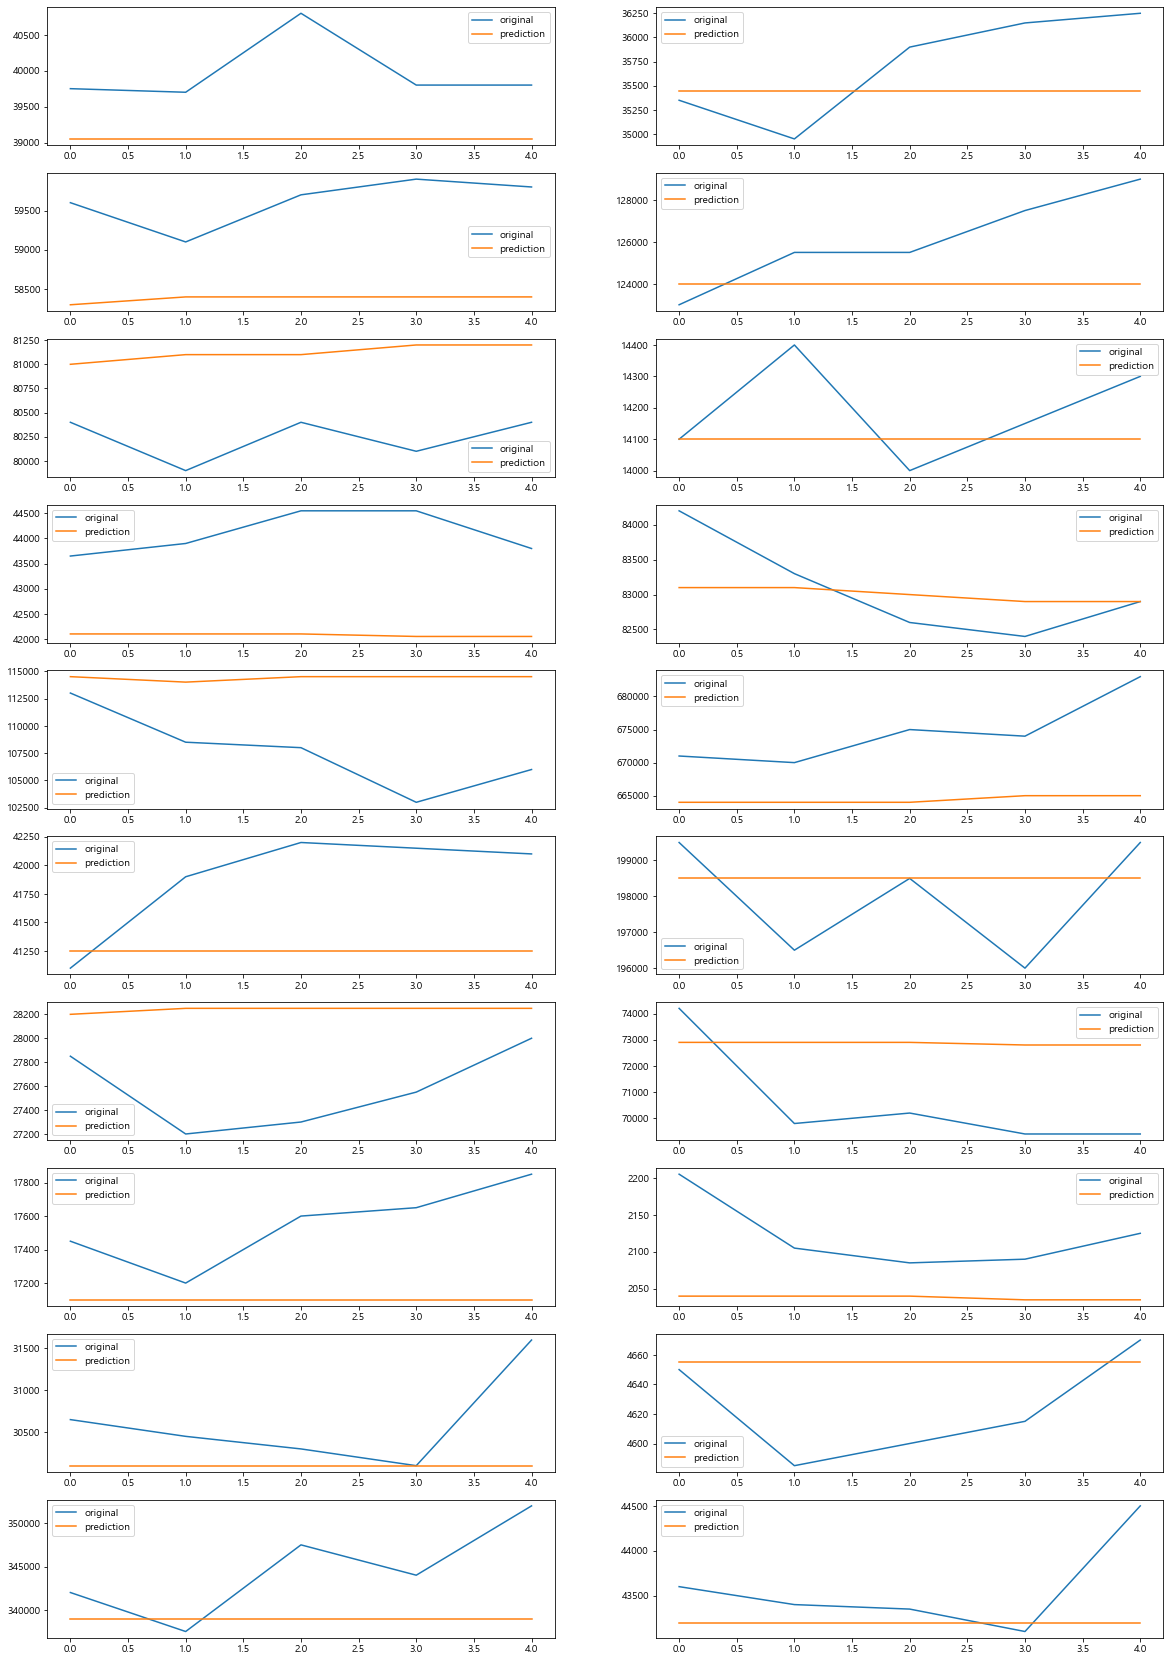

In [481]:
err, out = calc_error(net, optimizer, True)
file1 = open("./submission.csv", "w") 
file1.write(out)
file1.close()

In [482]:
def save_model(cur_epoch, error):
    torch.save({
        'model': net.state_dict(),
        'optimizer': optimizer.state_dict()
    }, './new_models/' + str(error * 100).replace('.', '_')  + '_' +  'all_32_1_20_10stocks_seq' + str(seq_length) + '_'+ start_year + '_EPOCH' + str(150+cur_epoch) +'.tar')
    # 모델 저장부분 - models 폴더에 모델들을 저장해놓음

In [483]:
def train(net, optimizer, epoch, printloss = True): # 학습
    errmin = 1.0
    for i in range(epoch):
        loss_avg = 0
        for cur_stock in range(stock_num):
            optimizer.zero_grad()
            outputs = net(train_dataX[cur_stock]).to(device)
            loss = criterion(outputs, train_dataY[cur_stock])
            loss.backward()
            optimizer.step()
            loss_avg += loss.item()
        if printloss:
            print('EPOCH :', i, 'loss :', loss_avg/stock_num)
        else:
            if (i + 1) % 50 == 0:
                err, out = calc_error(net, optimizer)
                if(errmin > err):
                    errmin = err
                    save_model(i + 1, err)
                
                print('EPOCH :', i + 1, 'loss :', loss_avg/stock_num, 'error :', err)
            if (i + 1) % 100 == 0:
                save_model(i + 1, err)
            

In [484]:

#train(net, optimizer, 2000, False)


In [485]:
"""
errormin = 999999
min_name=''
inp = input().split('-a----')
for lines in inp:
    if len(lines.split()) > 0:
        name = lines.split()[-1]

        try:
            net.load_state_dict(
                torch.load("./new_models/" + name)['model']
            )

            optimizer.load_state_dict(
                torch.load("./new_models/" + name)['optimizer']
            )

            err, out = calc_error(net, optimizer, False)
            print(err)
            if(err <= errormin):
                errormin = err
                min_name = name
        except:
            pass
"""


'\nerrormin = 999999\nmin_name=\'\'\ninp = input().split(\'-a----\')\nfor lines in inp:\n    if len(lines.split()) > 0:\n        name = lines.split()[-1]\n\n        try:\n            net.load_state_dict(\n                torch.load("./new_models/" + name)[\'model\']\n            )\n\n            optimizer.load_state_dict(\n                torch.load("./new_models/" + name)[\'optimizer\']\n            )\n\n            err, out = calc_error(net, optimizer, False)\n            print(err)\n            if(err <= errormin):\n                errormin = err\n                min_name = name\n        except:\n            pass\n'